In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output("ls ../input", shell = True).decode("utf8"))

# Any results you write to the current directory are saved as output.

holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
test_sample.csv
train.csv
train_sample.csv
transactions.csv



# train.csv

In [120]:
# load in the training data
# the number of rows (approximately) that should be loaded.  Set this negative to get all the data
numDesiredRows = 1000000

if numDesiredRows < 0:
    skiprows = 0
else:
    step = math.ceil(125000000. / numDesiredRows)
    skiprows = lambda x: x != 0 and x % step != 0

train_df = pd.read_csv('../input/train.csv', header = 0, index_col = 'id', 
                       parse_dates = ['date'], dtype = {'onpromotion': bool}, skiprows = skiprows)

print("Number of rows: %d\n" % (len(train_df)))
print("Columns: %s\n" % (train_df.columns))
print("Data types:\n%s\n" % (train_df.dtypes))
print("Column has missing values:\n%s\n" % (train_df.isnull().any()))

Number of rows: 1003976

Columns: Index([u'date', u'store_nbr', u'item_nbr', u'unit_sales', u'onpromotion'], dtype='object')

Data types:
date           datetime64[ns]
store_nbr               int64
item_nbr                int64
unit_sales            float64
onpromotion            object
dtype: object

Column has missing values:
date           False
store_nbr      False
item_nbr       False
unit_sales     False
onpromotion     True
dtype: bool



In [47]:
# Take a look at the first few rows
train_df.head(5)

,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
124,2013-01-01,25,315322,1.0,NaN
249,2013-01-01,25,564533,1.0,NaN
374,2013-01-01,25,809183,1.0,NaN
499,2013-01-01,25,1004550,32.0,NaN
624,2013-01-02,1,127534,4.0,NaN


In [49]:
# get some basic summary stats for the number of sales
train_df['unit_sales'].describe()

count    1.003976e+06
mean     8.562639e+00
std      2.033525e+01
min     -5.500000e+01
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      4.809000e+03
Name: unit_sales, dtype: float64

In [50]:
# we're told a negative unit_sales means items were returned.  Check how often that occurs
len(train_df[train_df.unit_sales < 0])

51

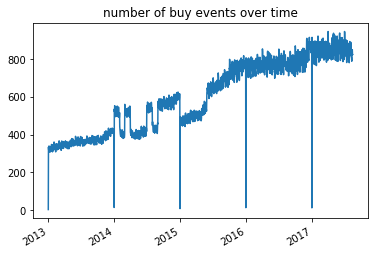

In [138]:
train_df['date'].value_counts().plot(title = "number of buy events over time")

In [52]:
#The number of buy events at different stores
train_df['store_nbr'].value_counts()

44    28131
45    27883
47    27654
3     27218
46    26810
49    26723
8     26086
48    25916
50    25534
6     24709
2     23906
51    23671
7     23377
37    22645
4     22633
9     22180
24    22163
38    21827
5     21354
39    21108
27    21024
11    20504
1     20482
41    20015
28    19371
23    18946
31    18908
34    18381
36    17703
18    17562
17    17312
40    16821
25    16449
33    15725
53    15529
15    15500
43    15495
19    15039
12    14715
16    14562
14    14462
26    14366
10    13952
13    13880
20    13305
54    13193
30    12752
29    12064
42    11720
35    11085
21    11016
32    10911
22     7378
52     2321
Name: store_nbr, dtype: int64

In [53]:
#The number of buy events at different stores
train_df['item_nbr'].value_counts()

692537     694
559870     691
162066     687
258396     684
414750     682
273528     681
1105212    677
839363     672
414353     661
315176     661
567623     660
115267     660
841842     660
850333     659
1146795    657
265559     655
314384     654
208384     654
1084881    653
1047772    653
847863     652
621300     652
502331     651
807493     648
261053     648
265279     647
1036689    647
938566     646
165594     645
1047681    645
          ... 
1988467      4
2090125      4
2089036      4
2089250      4
2062477      4
2087409      3
2054300      3
2056876      3
1939239      3
2010082      3
2122188      3
2088946      3
2035576      3
2089224      3
2011450      2
2045493      2
2011457      2
2008567      1
2011448      1
1993625      1
2123727      1
2123775      1
2127114      1
2120723      1
2075374      1
2123711      1
2122868      1
2123750      1
2123791      1
2011451      1
Name: item_nbr, Length: 4006, dtype: int64

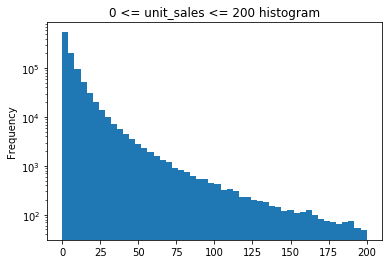

In [139]:
# distribution of the number of items being bought
upper_cutoff = 200
pos_sales = train_df.unit_sales >= 0
small_sales = train_df.unit_sales <= upper_cutoff
train_df.unit_sales[pos_sales & small_sales].plot.hist(bins = 50, log=True, title = "0 <= unit_sales <= %d histogram" % (upper_cutoff))

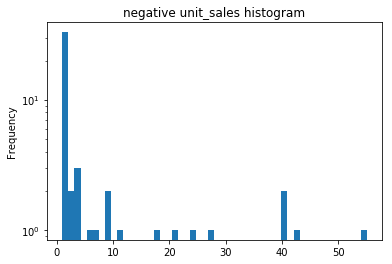

In [140]:
# distribution of the number of items being returned
train_df[train_df.unit_sales < 0].unit_sales.apply(lambda x: -x).plot.hist(bins = 50, log = True, title = "negative unit_sales histogram")

In [56]:
# check how many of the onpromotion values are missing, how many are true, and how many are false
naOnPromotions = train_df[pd.isna(train_df.onpromotion)]
onPromotions = train_df[train_df.onpromotion == True]
notOnPromotions = train_df[train_df.onpromotion == False]
print("num NA onpromotion: %d\nnum onpromotion: %d\nnum not onpromotion: %d\ntotal: %d" % 
              (len(naOnPromotions), len(onPromotions), len(notOnPromotions), len(train_df)))

num NA onpromotion: 173261
num onpromotion: 62717
num not onpromotion: 767998
total: 1003976


Based on the counts above, as well as just common sense, it seems like missing onpromotion values should probably be filled in as being False

# oil.csv

In [121]:
# load in the oil data
oil_df = pd.read_csv('../input/oil.csv', header = 0 , index_col = 'date', 
                     parse_dates = ['date'], names = ['date', 'price'], dtype = {'price': np.dtype('float64')})

print("Number of rows: %d\n" % (len(oil_df)))
print("Columns: %s\n" % (oil_df.columns))
print("Data types:\n%s\n" % (oil_df.dtypes))
print("Column has missing values:\n%s\n" % (oil_df.isnull().any()))

Number of rows: 1218

Columns: Index([u'price'], dtype='object')

Data types:
price    float64
dtype: object

Column has missing values:
price    True
dtype: bool



In [58]:
# examine the first few rows
oil_df.head(5)

,price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [59]:
# some basic stats about the oil prices
oil_df.describe()

,price
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


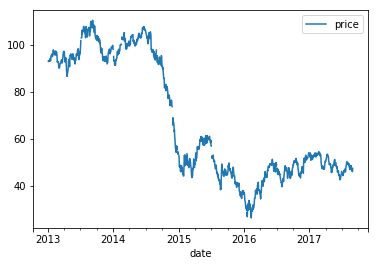

In [60]:
# check the oil price over time graph
oil_df.plot()

In [61]:
# get the number of dates with oil price and the number without 
numNA = len(oil_df.price[pd.isna(oil_df.price)])
print("w/ oil price: %d    w/o oil price: %d" % (len(oil_df) - numNA, numNA))

w/ oil price: 1175    w/o oil price: 43


In [62]:
# check how long the consecutive runs of missing data are
consecMissing = [0]
for date in oil_df.index:
    if pd.isna(oil_df.price[date]):
        consecMissing[-1] += 1
    elif consecMissing[-1] > 0:
        consecMissing.append(0)
        
if consecMissing[-1] == 0:
    consecMissing = consecMissing[:-1]
        
print(consecMissing)
print(sum(consecMissing))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
43


We see that there is at most two days in a row missing oil prices, so it would probably be fine to simply interpolate the price to get rid of the missing values.

# items

In [122]:
# load in the items data
item_df = pd.read_csv('../input/items.csv', header = 0, dtype = {'perishable': bool}, index_col = 'item_nbr')

print("Number of rows: %d\n" % (len(item_df)))
print("Columns: %s\n" % (item_df.columns))
print("Data types:\n%s\n" % (item_df.dtypes))
print("Column has missing values:\n%s\n" % (item_df.isnull().any()))

Number of rows: 4100

Columns: Index([u'family', u'class', u'perishable'], dtype='object')

Data types:
family        object
class          int64
perishable      bool
dtype: object

Column has missing values:
family        False
class         False
perishable    False
dtype: bool



In [64]:
# examine the first few items
item_df.head(5)

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,False
99197,GROCERY I,1067,False
103501,CLEANING,3008,False
103520,GROCERY I,1028,False
103665,BREAD/BAKERY,2712,True


### item families

In [68]:
print("Number of different families: %d" % (item_df.family.nunique()))

Number of different families: 33


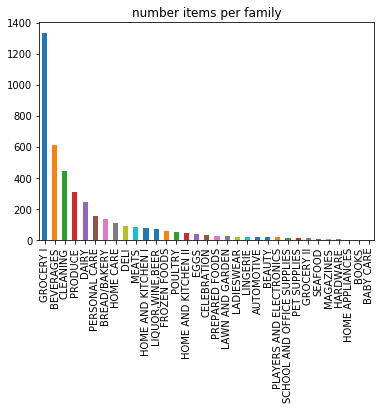

In [141]:
# number of items which belong to each of the families
item_df.family.value_counts().plot.bar(title = "number items per family")

### item classes

In [73]:
print("Number of unique item classes: %d" %(item_df['class'].nunique()))

Number of unique item classes: 337


In [75]:
# number of items which are in each of the classes
item_df['class'].value_counts()

1016    133
1040    110
1124    100
1034     98
1122     81
1072     70
1032     65
1148     62
1120     61
3020     60
2302     59
1026     54
3106     53
1042     51
1030     51
1028     48
1114     42
3034     41
2006     41
1190     40
4126     40
1074     39
1004     39
1142     37
1126     36
2502     36
2420     36
3046     35
1144     35
2008     34
       ... 
1018      1
6393      1
1336      1
6301      1
1380      1
6022      1
2024      1
4139      1
6230      1
6238      1
4255      1
6322      1
6426      1
2340      1
2412      1
2640      1
2784      1
2864      1
1005      1
1029      1
1041      1
3116      1
1089      1
1153      1
4140      1
2103      1
6233      1
4212      1
4228      1
6155      1
Name: class, Length: 337, dtype: int64

### item perishable status

In [77]:
perishableItems = item_df[item_df.perishable]
print("Num perishable: %d,   Num not perishable: %d" % (len(perishableItems), len(item_df) - len(perishableItems)))

Num perishable: 986,   Num not perishable: 3114


### checking connection between class and family

In [84]:
print("The maximum number of families that any class belongs to: %d" % (item_df.groupby('class')['family'].nunique().max()))

The maximum number of families that any class belongs to: 1


The cell above tells us that the classes are subcategories of the families

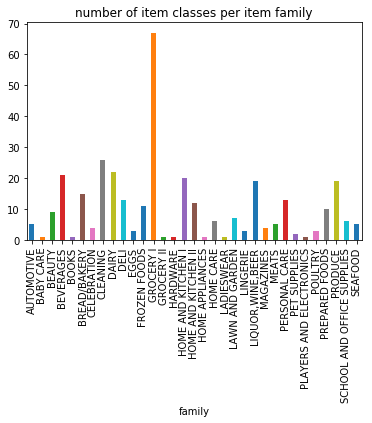

In [143]:
classesPerFamily.plot.bar(title = "number of item classes per item family")

### checking connection between perishable status and family/class

In [90]:
eachClassHomForPerishable = item_df.groupby('class')['perishable'].nunique().max() == 1
print("Each class contains only perishable or only non-perishable: %s" % (eachClassHomForPerishable))

Each class contains only perishable or only non-perishable: True


In [105]:
print("number of classes for with each perishable value: %s" % (item_df.groupby('perishable')['class'].nunique()))

number of classes for with each perishable value: perishable
False    242
True      95
Name: class, dtype: int64


In [110]:
eachFamilyHomForPerishable = item_df.groupby('family')['perishable'].nunique().max() == 1
print("Each family contains only perishable or only non-perishable: %s" % (eachFamilyHomForPerishable))

Each family contains only perishable or only non-perishable: True


In [111]:
print("number of families for with each perishable value: %s" % (item_df.groupby('perishable')['family'].nunique()))

number of families for with each perishable value: perishable
False    24
True      9
Name: family, dtype: int64


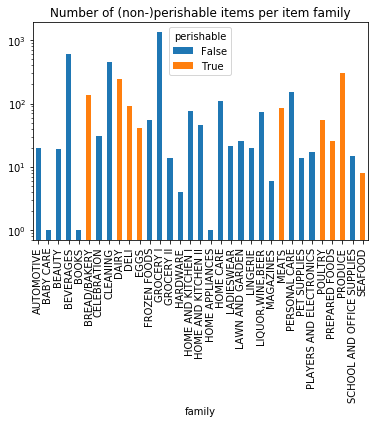

In [144]:
item_df.groupby(['family', 'perishable']).size().unstack().plot.bar(stacked = True, log = True, title = "Number of (non-)perishable items per item family")

# Stores

In [124]:
# load in the stores data
store_df = pd.read_csv('../input/stores.csv', header = 0, index_col = 'store_nbr')

print("Number of rows: %d\n" % (len(store_df)))
print("Columns: %s\n" % (store_df.columns))
print("Data types:\n%s\n" % (store_df.dtypes))
print("Column has missing values:\n%s\n" % (store_df.isnull().any()))

Number of rows: 54

Columns: Index([u'city', u'state', u'type', u'cluster'], dtype='object')

Data types:
city       object
state      object
type       object
cluster     int64
dtype: object

Column has missing values:
city       False
state      False
type       False
cluster    False
dtype: bool



In [125]:
# see the first few stores
store_df.head(5)

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### city

In [126]:
noCityNamesRepeatedInDifferentStates = store_df.groupby('city')['state'].nunique().max() == 1
print("There are no cities with the same name in different states: %s" % (noCityNamesRepeatedInDifferentStates))

There are no cities with the same name in different states: True


In [127]:
print("number of cities: %d" % (store_df.city.nunique()))

number of cities: 22


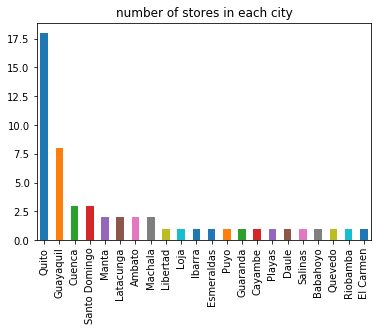

In [134]:
store_df.city.value_counts().plot.bar(title = "number of stores in each city")

### state

In [129]:
print("number of states: %d" % (store_df.state.nunique()))

number of states: 16


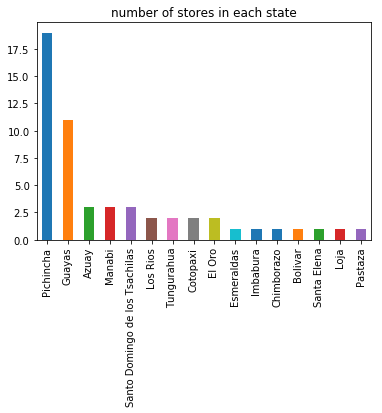

In [136]:
store_df.state.value_counts().plot.bar(title = "number of stores in each state")

### state / city interactions

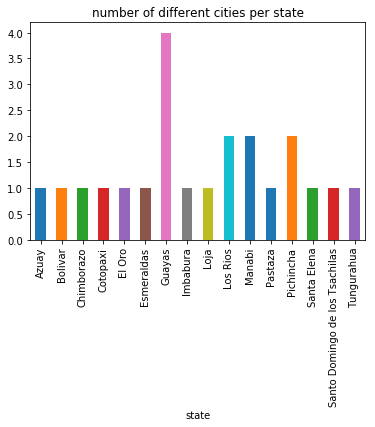

In [145]:
store_df.groupby('state').city.nunique().plot.bar(title = "number of different cities per state")

In [152]:
print("Number of stores per (state, city):\n%s" % (store_df.groupby(['state', 'city']).size()))

Number of stores per (state, city):
state                           city         
Azuay                           Cuenca            3
Bolivar                         Guaranda          1
Chimborazo                      Riobamba          1
Cotopaxi                        Latacunga         2
El Oro                          Machala           2
Esmeraldas                      Esmeraldas        1
Guayas                          Daule             1
                                Guayaquil         8
                                Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Loja                            Loja              1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
                                Manta             2
Pastaza                         Puyo              1
Pichincha                       Ca

### type

In [153]:
print("Number of different types: %d" % (store_df.type.nunique()))

Number of different types: 5


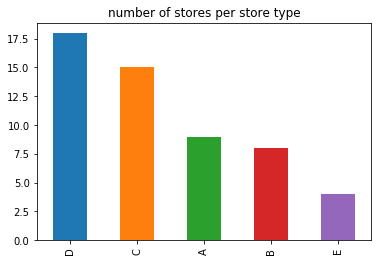

In [154]:
store_df.type.value_counts().plot.bar(title = "number of stores per store type")

### type / (city/state) interactions

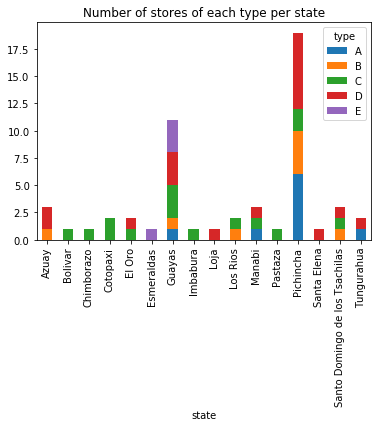

In [158]:
store_df.groupby(['state', 'type']).size().unstack().plot.bar(stacked = True, title = "Number of stores of each type per state")

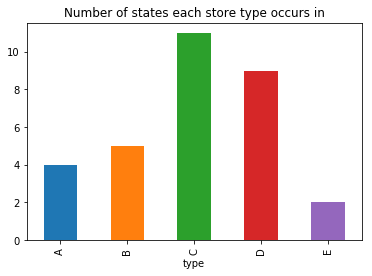

In [156]:
store_df.groupby('type').state.nunique().plot.bar(title = "Number of states each store type occurs in")

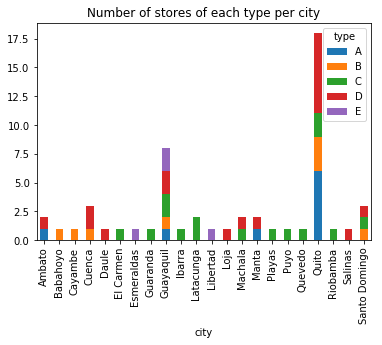

In [157]:
store_df.groupby(['city', 'type']).size().unstack().plot.bar(stacked = True, title = "Number of stores of each type per city")

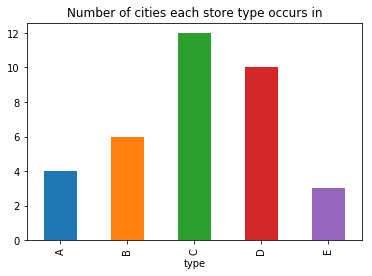

In [159]:
store_df.groupby('type').city.nunique().plot.bar(title = "Number of cities each store type occurs in")

### cluster

In [161]:
print("number of different clusters: %d" % (store_df.cluster.nunique()))

number of different clusters: 17


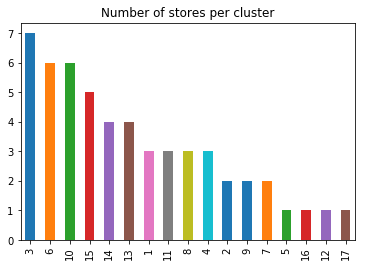

In [163]:
store_df.cluster.value_counts().plot.bar(title = "Number of stores per cluster")

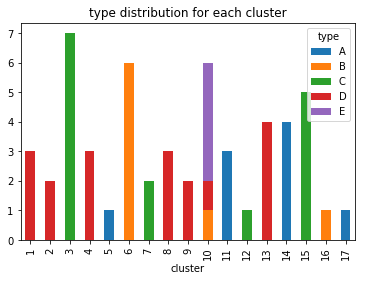

In [166]:
store_df.groupby(['cluster', 'type']).size().unstack().plot.bar(stacked = True, title = "type distribution for each cluster")

The above shows us that for the most part, store clusters are sub-categories of store type.  This is only not true for cluster 10, which contains stores of several different types.